In [ ]:
import sys, os, fnmatch, datetime, subprocess, imp
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from maxentpy import maxent_fast as ment
from maxentpy.maxent_fast import load_matrix

In [42]:
import math

In [ ]:
match_dct = {
    'A':'T',
    'C':'G',
    'T':'A',
    'G':'C',
}

In [ ]:
def reverse_complement(umi):
    if len(umi) == 0:
        return ''
    try:
        this = match_dct[umi[-1:]]
    except:
        print(umi)
        this = ''
    return this + reverse_complement(umi[:-1])

In [4]:
matrix3 = load_matrix(3)

In [5]:
complete_df = pd.read_csv('new_maxent_mers.csv')

/home/clara/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
complete_df = complete_df.drop(['insert_length', 'deletion_length', 'in_genotype', 'target', 'lib'], axis=1)

In [7]:
complete_df['maxent_score'] = complete_df.maxent_mer.apply(lambda x: ment.score3(x, matrix=matrix3))

In [15]:
wild_type = pd.read_csv('061318_exonskipping_library.csv')

In [16]:
wild_type['sequence_23'] = wild_type['Designed 61-bp target site (37i-24e, AG)'].apply(lambda x: x[17:40])

In [17]:
wild_type['maxent_mer'] = wild_type['Designed 61-bp target site (37i-24e, AG)'].apply(lambda x: ment.score3(x[17:40], matrix = matrix3))

In [18]:
wild_type = wild_type.rename(columns={'Identifier number':'id'})

In [19]:
wild_type_dict = pd.Series(wild_type.maxent_mer.values, index=wild_type.id).to_dict()

In [ ]:
plot = plt.hist(wild_type.maxent_mer, bins=50)
txt = plt.title('Wild type maxent score distribution')

In [ ]:
plot = plt.hist(df.score, bins=50)
txt = plt.title('Predicted maxent score distribution')

In [9]:
insertion = complete_df.loc[complete_df.Category == 'ins']
ins_percentage = insertion.groupby(['library_key'])['Predicted frequency'].sum().reset_index('library_key')
ins_percentage_dict = pd.Series(ins_percentage['Predicted frequency'].values, index = ins_percentage.library_key).to_dict()

In [10]:
insertion['Predicted frequency'] = insertion.apply(lambda x: x['Predicted frequency']/ins_percentage_dict[x.library_key], axis=1)

/home/clara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
insertion['score'] = insertion.maxent_score * insertion['Predicted frequency']

/home/clara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


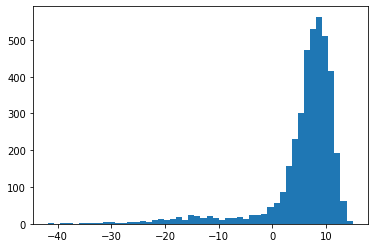

In [20]:
ins_weighted = insertion.groupby('library_key')['score'].sum()
ins_weighted = ins_weighted.reset_index('library_key').rename(columns={'library_key':'id'})
plot = plt.hist(ins_weighted.score, bins=50)

In [21]:
ins_weighted['wild_type'] = ins_weighted.id.apply(lambda x: wild_type_dict[x])

0.88

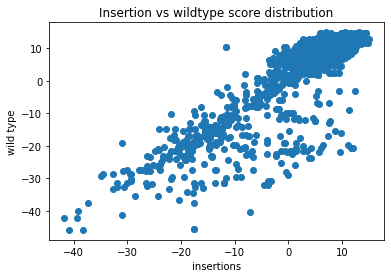

In [22]:
plot = plt.scatter(ins_weighted.score, ins_weighted.wild_type)
plt.xlabel('insertions')
plt.ylabel('wild type')
plt.title('Insertion vs wildtype score distribution')
round(np.corrcoef(ins_weighted.score, ins_weighted.wild_type)[0,1],2)

In [ ]:
complete_df.loc[complete_df.maxent_score > 3]

In [30]:
total_percentage = complete_df.groupby(['library_key'])['Predicted frequency'].sum().reset_index('library_key')
total_percentage_dict = pd.Series(total_percentage['Predicted frequency'].values, index = total_percentage.library_key).to_dict()

In [31]:
complete_df['Predicted frequency'] = complete_df.apply(lambda x: x['Predicted frequency']/total_percentage_dict[x.library_key], axis=1)

In [32]:
complete_df['score'] = complete_df.maxent_score * complete_df['Predicted frequency']

In [33]:
df = complete_df.groupby('library_key')['score'].sum()

In [34]:
df = df.reset_index('library_key').rename(columns={'library_key':'id'})

In [ ]:
df.score.sort_values()

In [35]:
df['wild_type'] = df.id.apply(lambda x: wild_type_dict[x])

Another way of calculating a probability (instead of score): everything above a certain threshold ==> spliced. Weighted average of spliced versus unspliced --> probability for each gRNA/target pair. How to choose threshold? From wildtype?

In [ ]:
plot = plt.scatter(df.score, df.wild_type)
plt.xlabel('predictions (ins and dels)')
plt.ylabel('wild type')
plt.title('Prediction (cas9) vs wildtype score distribution')
round(np.corrcoef(df.score, df.wild_type)[0,1],2)

In [37]:
score_dict = pd.Series(df.score.values, index = df.id).to_dict()

In [85]:
wild_dict = pd.Series(df.wild_type.values, index = df.id).to_dict()

In [28]:
b6 = pd.read_csv('b6_match_all.csv')
b6 = b6.drop('id', axis=1).rename(columns={'real_id':'id'})

In [47]:
def b_count(b6_match):
    b6_ids = b6_match.id.unique()
    all_scores = b6_match.groupby('id')['slice_type'].value_counts(normalize=True).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('id').rename(columns = {0:'percent'})
    b_scores = all_scores.loc[lambda x: x.slice_type == 'b']
    b_score_dict = pd.Series(b_scores.slice_type.values, index = b_scores.id).to_dict()
    for x in b6_ids:
        if x not in b_score_dict:
            b_scores = b_scores.append({'id':x, 'slice_type':'b', 'percent': 0.0}, ignore_index=True)
    return b_scores

In [ ]:
b6.groupby().

In [72]:
def c_count(b6_match):
    b6_ids = b6_match.id.unique()
    all_scores = b6_match.groupby('id')['slice_type'].value_counts(normalize=True).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('id').rename(columns = {0:'percent'})
    c_scores = all_scores.loc[lambda x: x.slice_type == 'c']
    c_score_dict = pd.Series(c_scores.slice_type.values, index = c_scores.id).to_dict()
    for x in b6_ids:
        if x not in c_score_dict:
            c_scores = c_scores.append({'id':x, 'slice_type':'c', 'percent': 0.0}, ignore_index=True)
    return c_scores

In [43]:
def log_to_prob(log):
    return math.exp(log)/(1 + math.exp(log))

In [106]:
b6.groupby('slice_type').size()

slice_type
b          107491
c           65496
cryptic     11841
dtype: int64

In [127]:
b6.slice_type.value_counts().loc['b']

107491

In [205]:
b6_c_fractions = b6_filtered.groupby('id').apply(lambda x: x.slice_type.value_counts().loc['c']/(x.slice_type.value_counts().loc['c']+x.slice_type.value_counts().loc['b'])
                                      if ('b' in x.slice_type.values) & ('c' in x.slice_type.values)
                                        else np.nan).rename("b6_c_fractions")

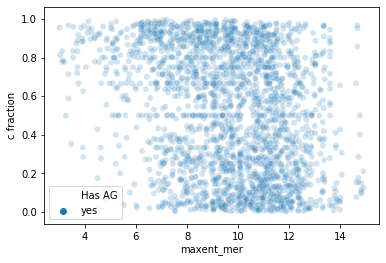

In [206]:
sns.scatterplot(data = b6_filtered.join(b6_c_fractions.rename('c fraction')).reset_index().drop_duplicates('id').loc[lambda x:x.maxent_mer > 3], alpha =.2, hue='Has AG', y= 'c fraction',x = 'maxent_mer')

AttributeError: 'PathCollection' object has no property 'hue'

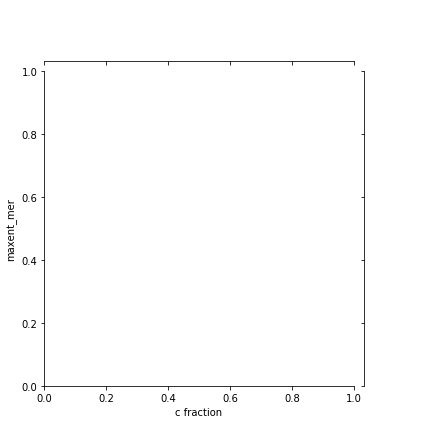

In [185]:
sns.jointplot(data = b6_filtered.join(df1.rename('c fraction')).reset_index().drop_duplicates('id'), hue='Has AG', x = 'c fraction', y = 'maxent_mer')

In [135]:
b6_filtered = b6.set_index('id').sort_index().join(wild_type.set_index('id'))

In [174]:
b3c = pd.read_csv("b3_cas9.csv")

In [179]:
b3c.loc[lambda x:x.genotype == 'del'].groupby("umi").genotype.value_counts()

umi              genotype
AAAAAAAATAACAAT  del         12
AAAAAAACTAGTACC  del          2
AAAAAAACTCACGCG  del          1
AAAAAAACTCTGCCA  del          5
AAAAAAAGTTATAGT  del          3
AAAAAAAGTTATATT  del          1
AAAAAACCCGACGGA  del          1
AAAAAACCCGAGGCA  del         22
AAAAAACCTCCCGAA  del          9
AAAAAACGTACTATA  del          1
AAAAAACTAACATAT  del          1
AAAAAACTGAGCTTG  del          9
AAAAAAGATATTTTT  del          5
AAAAAAGTAATTTTG  del          1
AAAAAAGTTGGCTAG  del          1
AAAAAATCTTTTGCT  del          1
AAAAAATGGCATGTT  del          3
AAAAAATTTCGGCAA  del          7
AAAAACCAACCGACA  del         30
AAAAACCACAATTCT  del          1
AAAAACCCTGTGGGG  del          2
AAAAACGAGGCGCGA  del          1
AAAAACTACGCTGTG  del         49
AAAAACTAGCGGAGG  del          2
AAAAAGAACTTTGTG  del         30
AAAAAGAGAGCTCCA  del          1
AAAAAGATACTTTAC  del          1
AAAAAGATAGCCTCC  del         18
AAAAAGATCATAAAT  del          4
AAAAAGATTGATCAT  del          1
              

In [171]:
b3m = pd.read_csv("b3_match.csv")

In [170]:
len(b3.drop_duplicates(subset=["umi"]))

1204501

In [169]:
len(b3.drop_duplicates())

2218103

In [167]:
len(b3)

16137320

In [163]:
len(b6[["umi"]].drop_duplicates())

27586

In [162]:
len(b6[["slice_type","umi"]].drop_duplicates())

36042

In [159]:
(len(b6),b6.umi.nunique())

(184828, 27586)

In [103]:
import seaborn as sns

In [121]:
c_probability.set_index('id').join(pd.Series(wild_dict).rename('wild_type frequency'))

,slice_type,percent,score,wild_type frequency
id,,,,
2,c,0.200000,6.123644,6.123644
4,c,0.500000,6.123644,6.123644
5,c,0.500000,6.123644,6.123644
6,c,0.666667,3.184193,3.184193
7,c,0.785714,3.184193,3.184193
8,c,1.000000,3.184193,3.184193
9,c,0.857143,3.184193,3.184193
11,c,1.000000,8.596525,8.596525
12,c,0.692308,8.596525,8.596525


(0.01, 0.99)

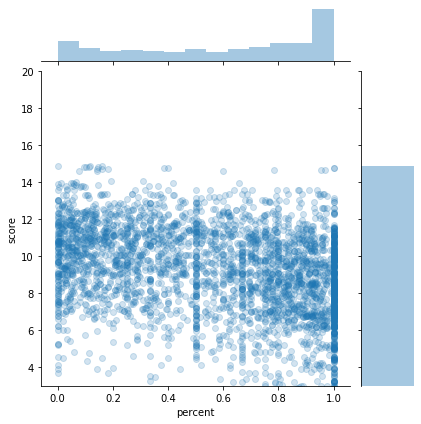

In [210]:
c_probability = c_count(b6)
c_probability['score'] = c_probability.id.apply(lambda x: wild_dict[x])
sns.jointplot(c_probability.percent, c_probability.score, alpha = 0.2)
plt.gca().set_ylim([3,20])
plt.gca().set_xlim([.01,.99])

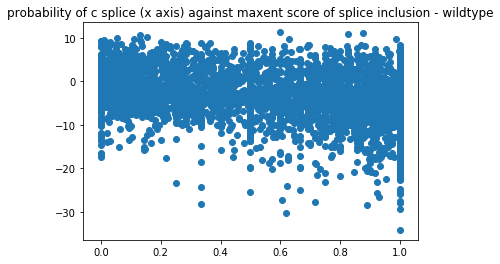

In [99]:
c_probability = c_count(b6)
c_probability['score'] = c_probability.id.apply(lambda x: score_dict[x])
# c_probability.score = c_probability.score.apply(lambda x: log_to_prob(x))
plt.scatter(c_probability.percent, c_probability.score)
title = plt.title('probability of c splice (x axis) against maxent score of splice inclusion - wildtype')

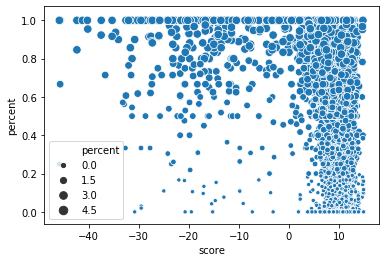

In [113]:
sns.scatterplot(x='score', y='percent', data = c_probability, size=c_probability.percent.apply(lambda x: x//.2))

## Q: How to convert scores into probability of splicing out?

log  odds frequency of splice inclusion